# Food Delivery Time estimation

## 1. Data Preparation

### 1.1 Import libraries

In [229]:
from module.distance_calculator import DistanceCalculator

import numpy as np
import pandas as pd

from math import sqrt, cos

import networkx as nx

import datetime
from datetime import time, date, datetime

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn import metrics


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate

### 1.2 Exploratory Data Analysis (EDA)

### 1.2.1 Examine data

In [230]:
# Read in the data
df = pd.read_excel("Capstone SampleData 14days.xlsx", sheet_name="Sheet1", header=0)

In [231]:
# Check the data types
df.head()

,JobAcceptedDate,jobAcceptedTime,calledMerchantTime,arrivedAtMerchantTime,mealPickedUpTime,arrivedAtCustLocationTime,foodDeliveredTime,riderInitial.lat,riderInitial.long,Merchant.Lat,Merchant.Lng,Customer.lat,Customer.lng,MerchantName,NationFoodCategory,FoodCategories
0,2020-10-03,20:39:15.840000,20:40:51.840000,20:48:19.840000,20:49:18.840000,21:14:09.840000,21:15:12.840000,13.825853,100.551958,13.825703,100.559309,13.756065,100.562375,3K SEA ZABB,Thai,อาหารทะเล
1,2020-10-01,12:54:34.560000,12:55:38.560000,13:10:26.560000,13:24:56.560000,14:01:00.560000,14:01:39.560000,13.819283,100.561874,13.831056,100.570731,13.774685,100.573913,ร้านอาหารอีสานแม่อลิส,Thai,อาหารอีสาน
2,2020-10-01,12:32:06.720000,12:32:21.720000,12:41:08.720000,12:46:41.720000,13:22:01.720000,13:22:53.720000,13.827041,100.554284,13.827205,100.536048,13.743898,100.571659,ไก่ย่างห้าดาว กรุงเทพ-นนท์44,Thai,Fast Food
3,2020-10-03,13:19:03.360000,13:20:04.360000,13:32:37.360000,13:45:46.360000,14:14:28.360000,14:15:47.360000,13.820453,100.557910,13.840180,100.542326,13.803957,100.513704,กิวกิวเต้ ประชาชื่น,Japanese,ปิ้งย่าง
4,2020-10-13,11:08:26.880000,11:09:03.880000,11:13:43.880000,11:15:32.880000,11:40:26.880000,11:41:23.880000,13.825773,100.567170,13.827034,100.564534,13.775817,100.575734,ร้านอาหาร วินเทส,Thai,อาหารตามสั่ง


In [7]:
# Check the data informations
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   JobAcceptedDate            10000 non-null  datetime64[ns]
 1   jobAcceptedTime            10000 non-null  object        
 2   calledMerchantTime         10000 non-null  object        
 3   arrivedAtMerchantTime      10000 non-null  object        
 4   mealPickedUpTime           10000 non-null  object        
 5   arrivedAtCustLocationTime  10000 non-null  object        
 6   foodDeliveredTime          10000 non-null  object        
 7   riderInitial.lat           10000 non-null  float64       
 8   riderInitial.long          10000 non-null  float64       
 9   Merchant.Lat               10000 non-null  float64       
 10  Merchant.Lng               10000 non-null  float64       
 11  Customer.lat               10000 non-null  float64       
 12  Custo

In [8]:
# Check the data shape
df.shape

(10000, 16)

### 1.2.2 Remove unused columns

In [9]:
# Remove the columns that are not needed
drop_list = ["calledMerchantTime",
             "arrivedAtMerchantTime",
             "foodDeliveredTime",
             "riderInitial.lat",
             "riderInitial.long",
             "MerchantName",
             "NationFoodCategory",
             "FoodCategories"]
try:
    df.drop(drop_list, axis=1, inplace=True)
except KeyError:
    print("Columns already removed")

display(df.head(3))

,JobAcceptedDate,jobAcceptedTime,mealPickedUpTime,arrivedAtCustLocationTime,Merchant.Lat,Merchant.Lng,Customer.lat,Customer.lng
0,2020-10-03,20:39:15.840000,20:49:18.840000,21:14:09.840000,13.825703,100.559309,13.756065,100.562375
1,2020-10-01,12:54:34.560000,13:24:56.560000,14:01:00.560000,13.831056,100.570731,13.774685,100.573913
2,2020-10-01,12:32:06.720000,12:46:41.720000,13:22:01.720000,13.827205,100.536048,13.743898,100.571659


### 1.2.3 Change data types (time, date -> datetime)
datetime data type can find interval but both time and date data types cannot.

In [10]:
def to_datetime(df, date_col, time_col):
    return pd.to_datetime(df[date_col].astype(str) + " " + df[time_col].astype(str))

In [11]:
if not isinstance(df["mealPickedUpTime"].iloc[0], datetime):
    df["mealPickedUpTime"]    = to_datetime(df, "JobAcceptedDate", "mealPickedUpTime")
if not isinstance(df["arrivedAtCustLocationTime"].iloc[0], datetime):
    df["arrivedAtCustLocationTime"] = to_datetime(df, "JobAcceptedDate", "arrivedAtCustLocationTime")

### 1.2.4 Create target from existed columns

In [12]:
df["DeliveryTime"] = df["arrivedAtCustLocationTime"] - df["mealPickedUpTime"]
df["DeliveryTime (s)"] = df["DeliveryTime"].apply(lambda x: x.total_seconds())
df["DeliveryTime (m)"] = df["DeliveryTime"].apply(lambda x: round(x.total_seconds()/60))

In [13]:
# Remove the columns that are not needed
drop_list = ["arrivedAtCustLocationTime",
             "mealPickedUpTime",
             "DeliveryTime"]
try:
    df.drop(drop_list, axis=1, inplace=True)
except KeyError:
    print("Columns already removed")

display(df.head(3))

,JobAcceptedDate,jobAcceptedTime,Merchant.Lat,Merchant.Lng,Customer.lat,Customer.lng,DeliveryTime (s),DeliveryTime (m)
0,2020-10-03,20:39:15.840000,13.825703,100.559309,13.756065,100.562375,1491.0,25
1,2020-10-01,12:54:34.560000,13.831056,100.570731,13.774685,100.573913,2164.0,36
2,2020-10-01,12:32:06.720000,13.827205,100.536048,13.743898,100.571659,2120.0,35


In [14]:
df.describe()

,Merchant.Lat,Merchant.Lng,Customer.lat,Customer.lng,DeliveryTime (s),DeliveryTime (m)
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,13.828060,100.559658,13.795584,100.564746,1821.204700,30.355000
std,0.005297,0.010585,0.044893,0.030013,755.673662,12.599034
min,13.811964,100.526637,13.738166,100.484028,181.000000,3.000000
25%,13.824620,100.555560,13.754118,100.544932,1245.000000,21.000000
50%,13.827034,100.563396,13.788780,100.564803,1814.000000,30.000000
75%,13.828517,100.564534,13.825360,100.580921,2375.000000,40.000000
max,13.843905,100.580416,13.914579,100.661622,4271.000000,71.000000


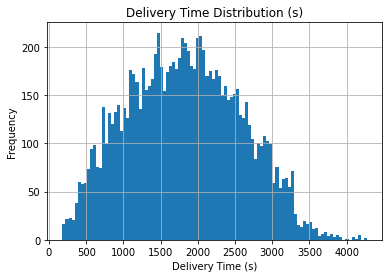

In [15]:
df["DeliveryTime (s)"].hist(bins=100)
plt.title("Delivery Time Distribution (s)")
plt.xlabel("Delivery Time (s)")
plt.ylabel("Frequency")
plt.show()

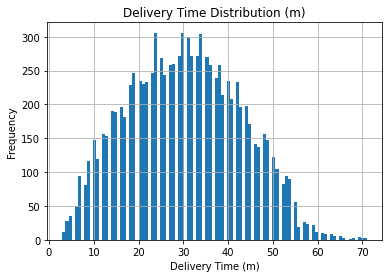

In [16]:
df["DeliveryTime (m)"].hist(bins=100)
plt.title("Delivery Time Distribution (m)")
plt.xlabel("Delivery Time (m)")
plt.ylabel("Frequency")
plt.show()

### 1.2.5 Add additional features

In [17]:
def get_euc(coords_1, coords_2):
    R = 6371000; conversion_const = 0.0174533
    c_1 = (coords_1[0]*conversion_const, coords_1[1]*conversion_const)
    c_2 = (coords_2[0]*conversion_const, coords_2[1]*conversion_const)
    delta_phi = abs(c_1[1]-c_2[1])
    theta = c_1[0]
    delta_theta = abs(c_1[0]-c_2[0])
    del_x = R*cos(theta)*delta_phi 
    del_y = R*delta_theta
    return sqrt(del_x**2 + del_y**2)

In [18]:
df["EucDist"] = df.apply(lambda x: get_euc((x["Merchant.Lat"],x["Merchant.Lng"]),(x["Customer.lat"],x["Customer.lng"])), axis=1)

In [19]:
mapper = {0:"Mon", 1:"Tue", 2:"Wed", 3:"Thu", 4:"Fri", 5:"Sat", 6:"Sun"} # TODO
df["day_of_week"] = df["JobAcceptedDate"].apply(lambda x: x.weekday())
df["day_of_week_name"] = df["JobAcceptedDate"].apply(lambda x: mapper[x.weekday()])

df["isHoliday"] = df["JobAcceptedDate"].apply(lambda x: int(x == pd.Timestamp('2020-10-13 00:00:00')))
df["isHoliday"] = ( df["isHoliday"] | ( (df["day_of_week"] == 5) | (df["day_of_week"] == 6) ) ).astype(int)

In [20]:
df.head()

,JobAcceptedDate,jobAcceptedTime,Merchant.Lat,Merchant.Lng,Customer.lat,Customer.lng,DeliveryTime (s),DeliveryTime (m),EucDist,day_of_week,day_of_week_name,isHoliday
0,2020-10-03,20:39:15.840000,13.825703,100.559309,13.756065,100.562375,1491.0,25,7750.511440,5,Sat,1
1,2020-10-01,12:54:34.560000,13.831056,100.570731,13.774685,100.573913,2164.0,36,6277.603705,3,Thu,0
2,2020-10-01,12:32:06.720000,13.827205,100.536048,13.743898,100.571659,2120.0,35,10029.576224,3,Thu,0
3,2020-10-03,13:19:03.360000,13.840180,100.542326,13.803957,100.513704,1722.0,29,5076.637568,5,Sat,1
4,2020-10-13,11:08:26.880000,13.827034,100.564534,13.775817,100.575734,1494.0,25,5822.057209,1,Tue,1


In [21]:
# One Hot encode
nominal_columns = ["day_of_week_name"]
dummy_df = pd.get_dummies(df[nominal_columns], drop_first=False)
df = pd.concat([df, dummy_df], axis=1)
df = df.drop(nominal_columns, axis=1)

In [22]:
df.head()

,JobAcceptedDate,jobAcceptedTime,Merchant.Lat,Merchant.Lng,Customer.lat,Customer.lng,DeliveryTime (s),DeliveryTime (m),EucDist,day_of_week,isHoliday,day_of_week_name_Fri,day_of_week_name_Mon,day_of_week_name_Sat,day_of_week_name_Sun,day_of_week_name_Thu,day_of_week_name_Tue,day_of_week_name_Wed
0,2020-10-03,20:39:15.840000,13.825703,100.559309,13.756065,100.562375,1491.0,25,7750.511440,5,1,0,0,1,0,0,0,0
1,2020-10-01,12:54:34.560000,13.831056,100.570731,13.774685,100.573913,2164.0,36,6277.603705,3,0,0,0,0,0,1,0,0
2,2020-10-01,12:32:06.720000,13.827205,100.536048,13.743898,100.571659,2120.0,35,10029.576224,3,0,0,0,0,0,1,0,0
3,2020-10-03,13:19:03.360000,13.840180,100.542326,13.803957,100.513704,1722.0,29,5076.637568,5,1,0,0,1,0,0,0,0
4,2020-10-13,11:08:26.880000,13.827034,100.564534,13.775817,100.575734,1494.0,25,5822.057209,1,1,0,0,0,0,0,1,0


In [23]:
## Try to convert one hot to angular distance (https://www.mikulskibartosz.name/time-in-machine-learning/)
df["day_of_week_sin"] = np.sin(df["day_of_week"]*(2.*np.pi/7))
df["day_of_week_cos"] = np.cos(df["day_of_week"]*(2.*np.pi/7))

In [24]:
df.head()

,JobAcceptedDate,jobAcceptedTime,Merchant.Lat,Merchant.Lng,Customer.lat,Customer.lng,DeliveryTime (s),DeliveryTime (m),EucDist,day_of_week,isHoliday,day_of_week_name_Fri,day_of_week_name_Mon,day_of_week_name_Sat,day_of_week_name_Sun,day_of_week_name_Thu,day_of_week_name_Tue,day_of_week_name_Wed,day_of_week_sin,day_of_week_cos
0,2020-10-03,20:39:15.840000,13.825703,100.559309,13.756065,100.562375,1491.0,25,7750.511440,5,1,0,0,1,0,0,0,0,-0.974928,-0.222521
1,2020-10-01,12:54:34.560000,13.831056,100.570731,13.774685,100.573913,2164.0,36,6277.603705,3,0,0,0,0,0,1,0,0,0.433884,-0.900969
2,2020-10-01,12:32:06.720000,13.827205,100.536048,13.743898,100.571659,2120.0,35,10029.576224,3,0,0,0,0,0,1,0,0,0.433884,-0.900969
3,2020-10-03,13:19:03.360000,13.840180,100.542326,13.803957,100.513704,1722.0,29,5076.637568,5,1,0,0,1,0,0,0,0,-0.974928,-0.222521
4,2020-10-13,11:08:26.880000,13.827034,100.564534,13.775817,100.575734,1494.0,25,5822.057209,1,1,0,0,0,0,0,1,0,0.781831,0.623490


In [26]:
D = DistanceCalculator()

In [27]:
nx.is_strongly_connected(D.G)

True

In [30]:
# tmp = df.iloc[:10].copy()
# tmp["Astar"] = tmp.apply(lambda x: D.shortestDistance((x["Merchant.Lat"], x["Merchant.Lng"]), (x["Customer.lat"], x["Customer.lng"])), axis=1)

In [32]:
# tmp[["EucDist", "Astar"]]

,EucDist,Astar
0,7750.511440,9679.275
1,6277.603705,7514.353
2,10029.576224,15891.237
3,5076.637568,10240.074
4,5822.057209,7381.359
5,9009.099000,11754.522
6,2543.767948,7182.951
7,8434.091849,11547.873
8,9004.200416,10383.466
9,9142.027755,13696.228


In [34]:
df["ShortestDist"] = 0

In [37]:
df[["EucDist", "ShortestDist"]]

,EucDist,ShortestDist
0,7750.511440,0
1,6277.603705,0
2,10029.576224,0
3,5076.637568,0
4,5822.057209,0
...,...,...
9995,10106.915791,0
9996,9770.186216,0
9997,4938.553701,0
9998,11773.601221,0


In [ ]:
# df.apply(lambda x: D.shortestDistance((x["Merchant.Lat"], x["Merchant.Lng"]), (x["Customer.lat"], x["Customer.lng"])), axis=1)

In [47]:
batch_size = 20
for i in range(0, df.shape[0], batch_size):
    print(i)
    df.loc[i:i+batch_size, "ShortestDist"] = df.loc[i:i+batch_size].apply(lambda x: D.shortestDistance((x["Merchant.Lat"], x["Merchant.Lng"]), (x["Customer.lat"], x["Customer.lng"])), axis=1)
    df.to_csv("Sample 14days (cleaned)", index=False)

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440
1460
1480
1500
1520
1540
1560
1580
1600
1620
1640
1660
1680
1700
1720
1740
1760
1780
1800
1820
1840
1860
1880
1900
1920
1940
1960
1980
2000
2020
2040
2060
2080
2100
2120
2140
2160
2180
2200
2220
2240
2260
2280
2300
2320
2340
2360
2380
2400
2420
2440
2460
2480
2500
2520
2540
2560
2580
2600
2620
2640
2660
2680
2700
2720
2740
2760
2780
2800
2820
2840
2860
2880
2900
2920
2940
2960
2980
3000
3020
3040
3060
3080
3100
3120
3140
3160
3180
3200
3220
3240
3260
3280
3300
3320
3340
3360
3380
3400
3420
3440
3460
3480
3500
3520
3540
3560
3580
3600
3620
3640
3660
3680
3700
3720
3740
3760
3780
3800
3820
3840
3860
3880
3900
3920
3940
3960
3980
4000
4020
4040
4060
4080
4100
4120
4140
4160
4180
4200
4

In [52]:
df[df["ShortestDist"] == 0]

,JobAcceptedDate,jobAcceptedTime,Merchant.Lat,Merchant.Lng,Customer.lat,Customer.lng,DeliveryTime (s),DeliveryTime (m),EucDist,day_of_week,...,day_of_week_name_Fri,day_of_week_name_Mon,day_of_week_name_Sat,day_of_week_name_Sun,day_of_week_name_Thu,day_of_week_name_Tue,day_of_week_name_Wed,day_of_week_sin,day_of_week_cos,ShortestDist
8863,2020-10-05,15:35:25.440000,13.82462,100.563396,13.824329,100.562859,531.0,9,66.398613,0,...,0,1,0,0,0,0,0,0.0,1.0,0.0


In [54]:
df[["EucDist", "ShortestDist"]]

,EucDist,ShortestDist
0,7750.511440,9679.275
1,6277.603705,7514.353
2,10029.576224,15891.237
3,5076.637568,10240.074
4,5822.057209,7381.359
...,...,...
9995,10106.915791,13555.731
9996,9770.186216,12598.117
9997,4938.553701,6917.962
9998,11773.601221,15830.093


In [50]:
# idx = 2
# u = df[["Merchant.Lat", "Merchant.Lng"]].iloc[idx].values
# v = df[["Customer.lat", "Customer.lng"]].iloc[idx].values

In [51]:
# D.shortestDistance(u, v)

15891.236999999997

### 1.2.6 Extract input/output for train model

In [29]:
# LOAD CLEANED DATASET
df = pd.read_csv("Sample 14days (cleaned)")

In [30]:
df[df["ShortestDist"]==0]

,JobAcceptedDate,jobAcceptedTime,Merchant.Lat,Merchant.Lng,Customer.lat,Customer.lng,DeliveryTime (s),DeliveryTime (m),EucDist,day_of_week,...,day_of_week_name_Fri,day_of_week_name_Mon,day_of_week_name_Sat,day_of_week_name_Sun,day_of_week_name_Thu,day_of_week_name_Tue,day_of_week_name_Wed,day_of_week_sin,day_of_week_cos,ShortestDist
8863,2020-10-05,15:35:25.440000,13.82462,100.563396,13.824329,100.562859,531.0,9,66.398613,0,...,0,1,0,0,0,0,0,0.0,1.0,0.0


In [31]:
df.loc[df["ShortestDist"]==0, "ShortestDist"] = df.loc[df["ShortestDist"]==0, "EucDist"]

In [32]:
df[df["ShortestDist"]==0]

,JobAcceptedDate,jobAcceptedTime,Merchant.Lat,Merchant.Lng,Customer.lat,Customer.lng,DeliveryTime (s),DeliveryTime (m),EucDist,day_of_week,...,day_of_week_name_Fri,day_of_week_name_Mon,day_of_week_name_Sat,day_of_week_name_Sun,day_of_week_name_Thu,day_of_week_name_Tue,day_of_week_name_Wed,day_of_week_sin,day_of_week_cos,ShortestDist


In [33]:
y_s = df.pop("DeliveryTime (s)")
y_m = df.pop("DeliveryTime (m)")
# # data without day of week
# selected_cols_1 = ["Merchant.Lat", "Merchant.Lng", "Customer.lat", "Customer.lng", "EucDist"]
# # data with day of week (onehot)
# selected_cols_2 = ["Merchant.Lat", "Merchant.Lng", "Customer.lat", "Customer.lng", "EucDist", "isHoliday",\
#     'day_of_week_name_Mon', 'day_of_week_name_Tue', 'day_of_week_name_Wed', 'day_of_week_name_Thu', 'day_of_week_name_Fri', 'day_of_week_name_Sat', 'day_of_week_name_Sun']
# # data with day of week (angular distance)
# selected_cols_3 = ["Merchant.Lat", "Merchant.Lng", "Customer.lat", "Customer.lng", "EucDist", "isHoliday", "day_of_week_sin",	"day_of_week_cos"]
selected_cols_1 = ["Merchant.Lat", "Merchant.Lng", "Customer.lat", "Customer.lng", "EucDist"]
selected_cols_2 = ["Merchant.Lat", "Merchant.Lng", "Customer.lat", "Customer.lng", "EucDist", "ShortestDist"]

X = [df[selected_cols_1].copy(), df[selected_cols_2].copy()]

## 3. Model Regression

### 3.1 Split data for train and test

In [34]:
Xs_trains = []; Xs_tests = []; ys_trains = []; ys_tests = []
Xm_trains = []; Xm_tests = []; ym_trains = []; ym_tests = []

for i in range(len(X)):
    Xs_train, Xs_test, ys_train, ys_test = train_test_split(X[i], y_s, test_size=0.20, random_state=0)
    Xm_train, Xm_test, ym_train, ym_test = train_test_split(X[i], y_m, test_size=0.20, random_state=0)
    Xs_trains.append(Xs_train); Xs_tests.append(Xs_test); ys_trains.append(ys_train); ys_tests.append(ys_test)
    Xm_trains.append(Xm_train); Xm_tests.append(Xm_test); ym_trains.append(ym_train); ym_tests.append(ym_test)

### 3.2 Model Metrics

In [35]:
met = pd.DataFrame({"Model": [], "MAE": [], "MSE": [], "RMSE": [], "R2": []})
model_metrics_s = [met.copy(), met.copy()]
model_metrics_m = [met.copy(), met.copy()]

### 3.3 Baseline model (Average)

In [36]:
all_predictions_s = [[],[]]; all_predictions_m = [[],[]]

### 3.3.1 As second

In [37]:
avg_predictions_s = np.full(len(ys_tests[i]), np.mean(ys_trains[i]))
for i in range(len(X)):
    MAE  = metrics.mean_absolute_error(ys_tests[i], avg_predictions_s)
    MSE  = metrics.mean_squared_error(ys_tests[i], avg_predictions_s)
    R2   = metrics.r2_score(ys_tests[i], avg_predictions_s)
    RMSE = np.sqrt(metrics.mean_squared_error(ys_test, avg_predictions_s))

    all_predictions_s[i].append(avg_predictions_s)
    model_metrics_s[i].loc[len(model_metrics_s[i])] = list(["Mean ", MAE, MSE, RMSE, R2])

### 3.3.2 As minute

In [38]:
avg_predictions_m =  np.full(len(ym_tests[i]), np.mean(ym_trains[i]))
for i in range(len(X)):
    MAE  = metrics.mean_absolute_error(ym_test, avg_predictions_m)
    MSE  = metrics.mean_squared_error(ym_test, avg_predictions_m)
    R2   = metrics.r2_score(ym_test, avg_predictions_m)
    RMSE = np.sqrt(metrics.mean_squared_error(ym_test, avg_predictions_m))

    all_predictions_m[i].append(avg_predictions_m)
    model_metrics_m[i].loc[len(model_metrics_m[i])] = list(["Mean ", MAE, MSE, RMSE, R2])

### 3.3 Linear Regression

#### 3.3.1 As second

In [39]:
for i in range(len(X)):
    lr = LinearRegression()
    lr.fit(Xs_trains[i], ys_trains[i])
    lr_predictions_s = lr.predict(Xs_tests[i])

    MAE  = metrics.mean_absolute_error(ys_tests[i], lr_predictions_s)
    MSE  = metrics.mean_squared_error(ys_tests[i], lr_predictions_s)
    R2   = metrics.r2_score(ys_tests[i], lr_predictions_s)
    RMSE = np.sqrt(metrics.mean_squared_error(ys_tests[i], lr_predictions_s))

    all_predictions_s[i].append(lr_predictions_s)
    model_metrics_s[i].loc[len(model_metrics_s[i])] = list(["Linear Regression", MAE, MSE, RMSE, R2])

#### 3.3.2 As minute

In [40]:
for i in range(len(X)):
    lr = LinearRegression()
    lr.fit(Xm_trains[i], ym_trains[i])
    lr_predictions_m = lr.predict(Xm_tests[i])
    lr_predictions_m = np.round(lr_predictions_m)

    MAE  = metrics.mean_absolute_error(ym_tests[i], lr_predictions_m)
    MSE  = metrics.mean_squared_error(ym_tests[i], lr_predictions_m)
    R2   = metrics.r2_score(ym_tests[i], lr_predictions_m)
    RMSE = np.sqrt(metrics.mean_squared_error(ym_tests[i], lr_predictions_m))

    all_predictions_m[i].append(lr_predictions_m)
    model_metrics_m[i].loc[len(model_metrics_m[i])] = list(["Linear Regression", MAE, MSE, RMSE, R2])

### 3.4 Random Forest

#### 3.4.1 As second

In [41]:
for i in range(len(X)):
    rf = RandomForestRegressor()
    rf.fit(Xs_trains[i], ys_trains[i])
    rf_predictions_s = rf.predict(Xs_tests[i])
    
    MAE  = metrics.mean_absolute_error(ys_tests[i], rf_predictions_s)
    MSE  = metrics.mean_squared_error(ys_tests[i], rf_predictions_s)
    R2   = metrics.r2_score(ys_tests[i], rf_predictions_s)
    RMSE = np.sqrt(metrics.mean_squared_error(ys_tests[i], rf_predictions_s))

    all_predictions_s[i].append(rf_predictions_s)
    model_metrics_s[i].loc[len(model_metrics_s[i])] = list(["Random Forest", MAE, MSE, RMSE, R2])

#### 3.4.2 As minute

In [42]:
for i in range(len(X)):
    rf = RandomForestRegressor()
    rf.fit(Xm_trains[i], ym_trains[i])
    rf_predictions_m = rf.predict(Xm_tests[i])
    rf_predictions_m = np.round(rf_predictions_m)

    MAE  = metrics.mean_absolute_error(ym_tests[i], rf_predictions_m)
    MSE  = metrics.mean_squared_error(ym_tests[i], rf_predictions_m)
    R2   = metrics.r2_score(ym_tests[i], rf_predictions_m)
    RMSE = np.sqrt(metrics.mean_squared_error(ym_tests[i], rf_predictions_m))

    all_predictions_m[i].append(rf_predictions_m)
    model_metrics_m[i].loc[len(model_metrics_m[i])] = list(["Random Forest", MAE, MSE, RMSE, R2])

### 3.5 Gradient Boosted Desicion Tree

#### 3.5.1 As second

In [43]:
for i in range(len(X)):
    gbdt = GradientBoostingRegressor(n_estimators=1000, max_depth=7, random_state=0)
    gbdt.fit(Xs_trains[i], ys_trains[i])
    gbdt_predictions_s = gbdt.predict(Xs_tests[i])
    
    MAE  = metrics.mean_absolute_error(ys_tests[i], gbdt_predictions_s)
    MSE  = metrics.mean_squared_error(ys_tests[i], gbdt_predictions_s)
    R2   = metrics.r2_score(ys_tests[i], gbdt_predictions_s)
    RMSE = np.sqrt(metrics.mean_squared_error(ys_tests[i], gbdt_predictions_s))

    all_predictions_s[i].append(gbdt_predictions_s)
    model_metrics_s[i].loc[len(model_metrics_s[i])] = list(["Gradient Boosted Decision Tree", MAE, MSE, RMSE, R2])

#### 3.5.2 As minute

In [44]:
for i in range(len(X)):
    gbdt = GradientBoostingRegressor(n_estimators=1000, max_depth=7, random_state=0)
    gbdt.fit(Xm_trains[i], ym_trains[i])
    gbdt_predictions_m = gbdt.predict(Xm_tests[i])
    gbdt_predictions_m = np.round(gbdt_predictions_m)

    MAE  = metrics.mean_absolute_error(ym_tests[i], gbdt_predictions_m)
    MSE  = metrics.mean_squared_error(ym_tests[i], gbdt_predictions_m)
    R2   = metrics.r2_score(ym_tests[i], gbdt_predictions_m)
    RMSE = np.sqrt(metrics.mean_squared_error(ym_tests[i], gbdt_predictions_m))

    all_predictions_m[i].append(gbdt_predictions_m)
    model_metrics_m[i].loc[len(model_metrics_m[i])] = list(["Gradient Boosted Decision Tree", MAE, MSE, RMSE, R2])

## 4. Model Evaluation

In [263]:
# DataFeats = ["Without day_of_week", "With day_of_week OneHot", "With day_of_week Angular"]
# table_names = ["Metrics without day_of_week as second", "Metrics with day_of_week_OneHot as second", "Metrics with day_of_week Angular as second"]
# for i in range(len(X)):
#     print(DataFeats[i])
#     display(model_metrics_s[i])
#     #model_metrics_s[i].to_csv(table_names[i] + ".csv", index=False)

Without day_of_week


,Model,MAE,MSE,RMSE,R2
0,Mean,619.032975,569247.206950,754.484729,-0.000018
1,Linear Regression,290.057970,123414.634860,351.304191,0.783193
2,Random Forest,304.076595,140851.843384,375.302336,0.752560
3,Gradient Boosted Decision Tree,314.644290,156384.984775,395.455414,0.725273


With day_of_week OneHot


,Model,MAE,MSE,RMSE,R2
0,Mean,619.032975,569247.206950,754.484729,-0.000018
1,Linear Regression,290.095703,123578.498894,351.537336,0.782905
2,Random Forest,298.640797,135167.856571,367.651814,0.762545
3,Gradient Boosted Decision Tree,314.223594,155374.114117,394.175233,0.727048


With day_of_week Angular


,Model,MAE,MSE,RMSE,R2
0,Mean,619.032975,569247.206950,754.484729,-0.000018
1,Linear Regression,290.095933,123514.896827,351.446862,0.783017
2,Random Forest,299.959626,136281.311776,369.162988,0.760589
3,Gradient Boosted Decision Tree,313.135096,155579.982773,394.436285,0.726687


In [47]:
DataFeats = ["Without ShortestPath", "With ShortestPath"]
table_names = ["Metrics without ShortestPath as second", "Metrics with ShortestPath as second"]
for i in range(len(X)):
    print(DataFeats[i])
    display(model_metrics_s[i])
    model_metrics_s[i].to_csv(table_names[i] + ".csv", index=False)

Without ShortestPath


,Model,MAE,MSE,RMSE,R2
0,Mean,619.032975,569247.206950,754.484729,-0.000018
1,Linear Regression,290.057970,123414.634860,351.304191,0.783193
2,Random Forest,303.498942,139596.666458,373.626373,0.754765
3,Gradient Boosted Decision Tree,314.644290,156384.984775,395.455414,0.725273


With ShortestPath


,Model,MAE,MSE,RMSE,R2
0,Mean,619.032975,569247.206950,754.484729,-0.000018
1,Linear Regression,290.124553,123369.152475,351.239452,0.783273
2,Random Forest,301.742940,138038.018263,371.534680,0.757503
3,Gradient Boosted Decision Tree,314.852248,155208.443214,393.965028,0.727339


In [264]:
# table_names = ["Metrics without day_of_week as minute", "Metrics with day_of_week_OneHot as minute", "Metrics with day_of_week Angular as minute"]
# for i in range(len(X)):
#     print(DataFeats[i])
#     display(model_metrics_m[i])
#     #model_metrics_m[i].to_csv(table_names[i] + ".csv", index=False)

Without day_of_week


,Model,MAE,MSE,RMSE,R2
0,Mean,10.326068,158.240588,12.579372,-0.000022
1,Linear Regression,4.838000,34.537000,5.876819,0.781739
2,Random Forest,5.072000,39.277000,6.267137,0.751784
3,Gradient Boosted Decision Tree,5.305000,44.232000,6.650714,0.720470


With day_of_week OneHot


,Model,MAE,MSE,RMSE,R2
0,Mean,10.326068,158.240588,12.579372,-0.000022
1,Linear Regression,4.836000,34.590000,5.881326,0.781404
2,Random Forest,5.003000,38.074000,6.170413,0.759386
3,Gradient Boosted Decision Tree,5.207500,42.824500,6.544043,0.729365


With day_of_week Angular


,Model,MAE,MSE,RMSE,R2
0,Mean,10.326068,158.240588,12.579372,-0.000022
1,Linear Regression,4.834500,34.478500,5.871840,0.782109
2,Random Forest,4.967000,37.516000,6.125031,0.762913
3,Gradient Boosted Decision Tree,5.205000,43.390000,6.587109,0.725791


In [48]:
table_names = ["Metrics without ShortestPath as minute", "Metrics with ShortestPath as minute"]
for i in range(len(X)):
    print(DataFeats[i])
    display(model_metrics_m[i])
    model_metrics_m[i].to_csv(table_names[i] + ".csv", index=False)

Without ShortestPath


,Model,MAE,MSE,RMSE,R2
0,Mean,10.326068,158.240588,12.579372,-0.000022
1,Linear Regression,4.838000,34.537000,5.876819,0.781739
2,Random Forest,5.093500,39.501500,6.285022,0.750365
3,Gradient Boosted Decision Tree,5.305000,44.232000,6.650714,0.720470


With ShortestPath


,Model,MAE,MSE,RMSE,R2
0,Mean,10.326068,158.240588,12.579372,-0.000022
1,Linear Regression,4.838000,34.484000,5.872308,0.782074
2,Random Forest,5.070000,38.999000,6.244918,0.753541
3,Gradient Boosted Decision Tree,5.220000,42.533000,6.521733,0.731207


# Knowledge

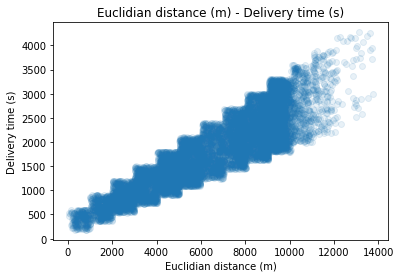

In [120]:
plt.scatter(df["EucDist"], y_s, alpha=0.1)
plt.title("Euclidian distance (m) - Delivery time (s)")
plt.xlabel("Euclidian distance (m)")
plt.ylabel("Delivery time (s)")
plt.show()

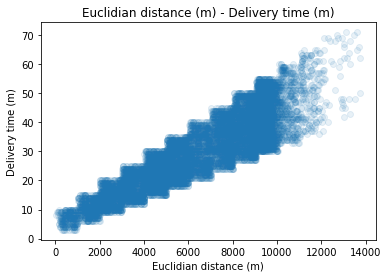

In [121]:
plt.scatter(df["EucDist"], y_m, alpha=0.1)
plt.title("Euclidian distance (m) - Delivery time (m)")
plt.xlabel("Euclidian distance (m)")
plt.ylabel("Delivery time (m)")
plt.show()

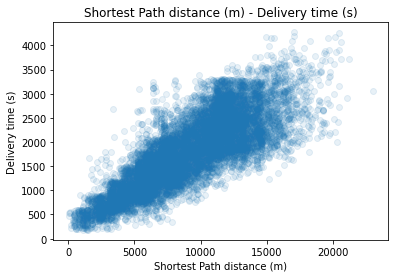

In [122]:
plt.scatter(df["ShortestDist"], y_s, alpha=0.1)
plt.title("Shortest Path distance (m) - Delivery time (s)")
plt.xlabel("Shortest Path distance (m)")
plt.ylabel("Delivery time (s)")
plt.show()

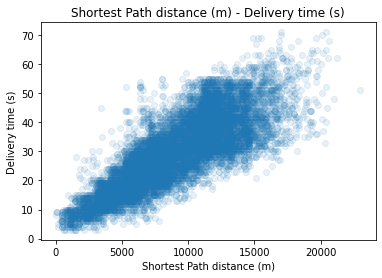

In [123]:
plt.scatter(df["ShortestDist"], y_m, alpha=0.1)
plt.title("Shortest Path distance (m) - Delivery time (s)")
plt.xlabel("Shortest Path distance (m)")
plt.ylabel("Delivery time (s)")
plt.show()

[]

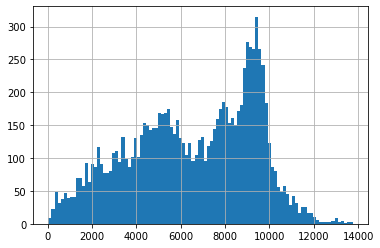

In [124]:
df["EucDist"].hist(bins=100)
plt.plot()

<AxesSubplot: >

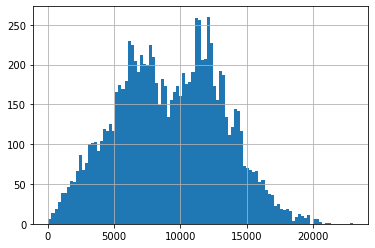

In [125]:
df["ShortestDist"].hist(bins=100)

# Model Variance

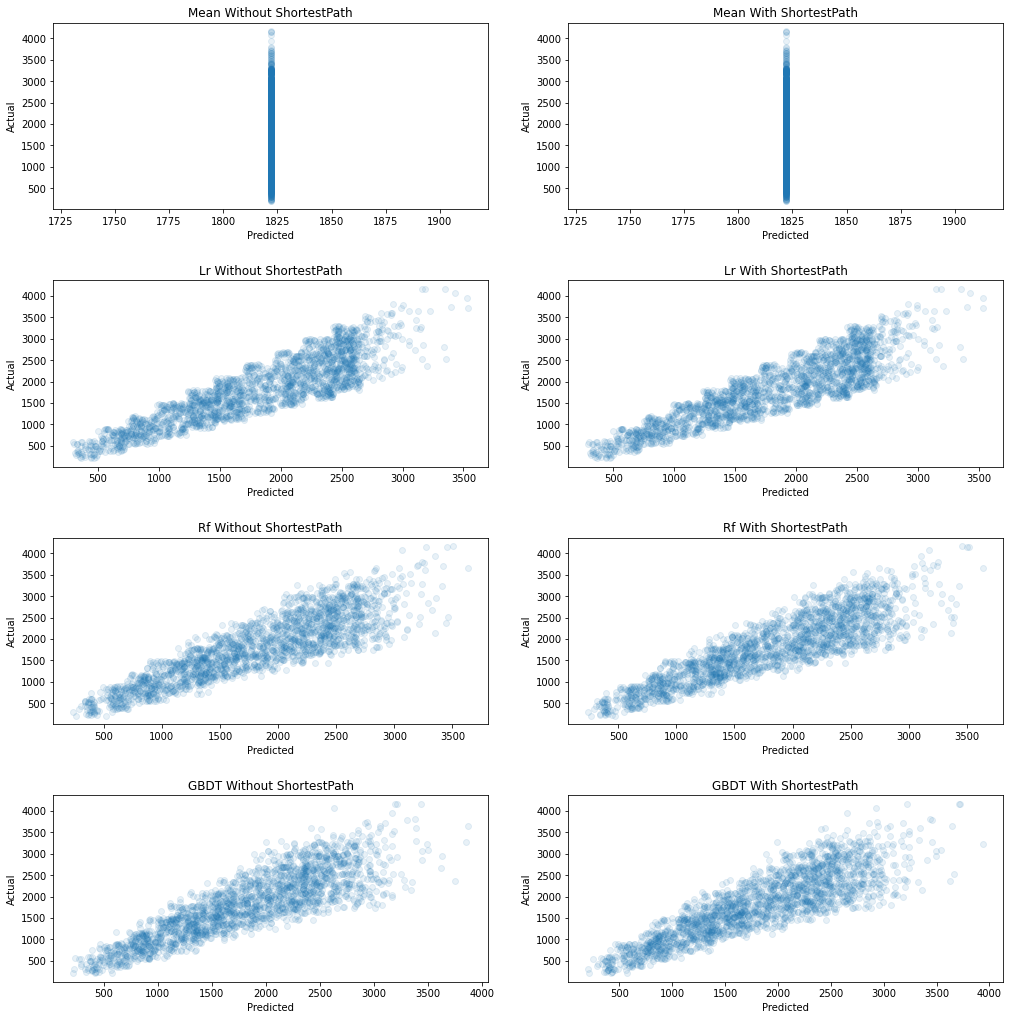

In [49]:
Names = ["Mean", "Lr", "Rf", "GBDT"]
#DataFeats
fig, axs = plt.subplots(len(Names), len(X), figsize=(15, 15))
fig.tight_layout(pad=5.0)
for i in range(len(Names)):
    for j in range(len(X)):
        axs[i, j].scatter(all_predictions_s[j][i], ys_tests[j], alpha=0.1)
        axs[i, j].set_title(Names[i]+" "+DataFeats[j])
        axs[i, j].set_xlabel("Predicted")
        axs[i, j].set_ylabel("Actual")

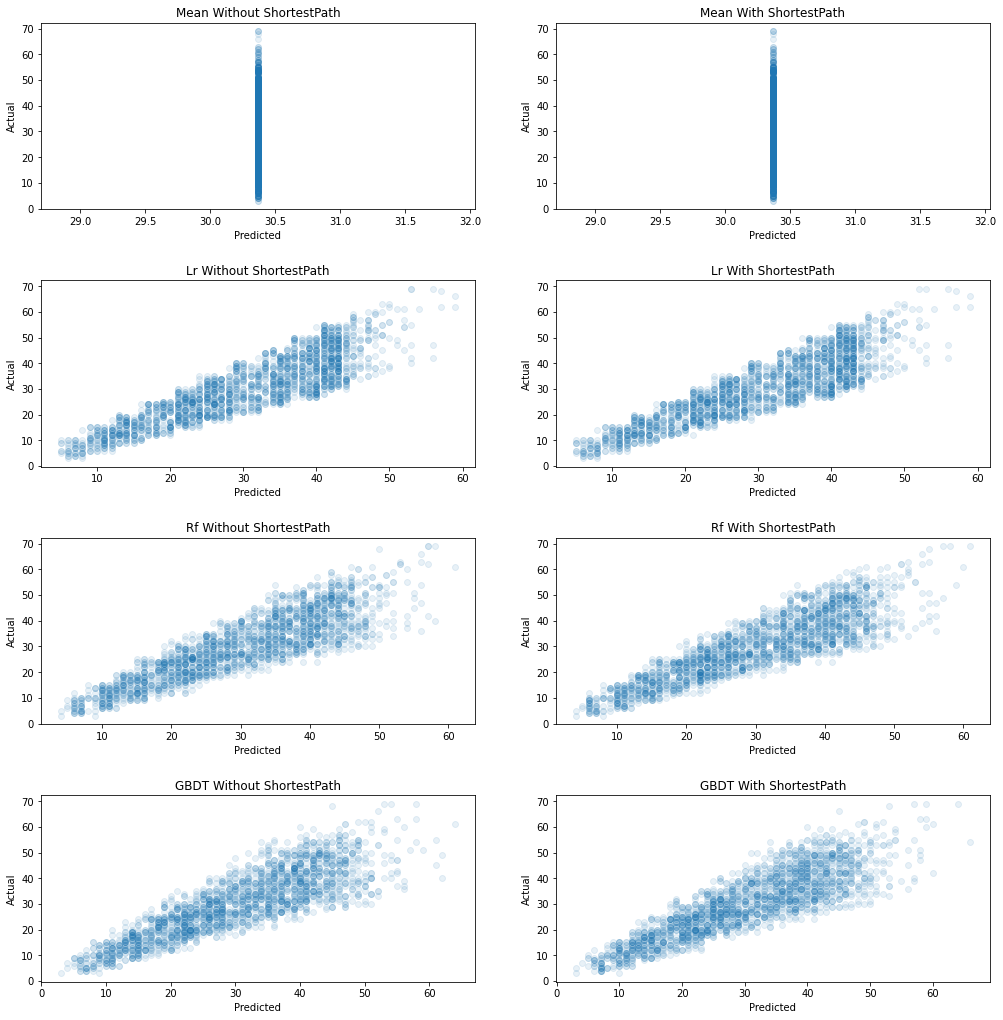

In [50]:
fig, axs = plt.subplots(len(Names), len(X), figsize=(15, 15))
fig.tight_layout(pad=5.0)
for i in range(len(Names)):
    for j in range(len(X)):
        axs[i, j].scatter(all_predictions_m[j][i], ym_tests[j],  alpha=0.1)
        axs[i, j].set_title(Names[i]+" "+DataFeats[j])
        axs[i, j].set_xlabel("Predicted")
        axs[i, j].set_ylabel("Actual")

# Error distribution

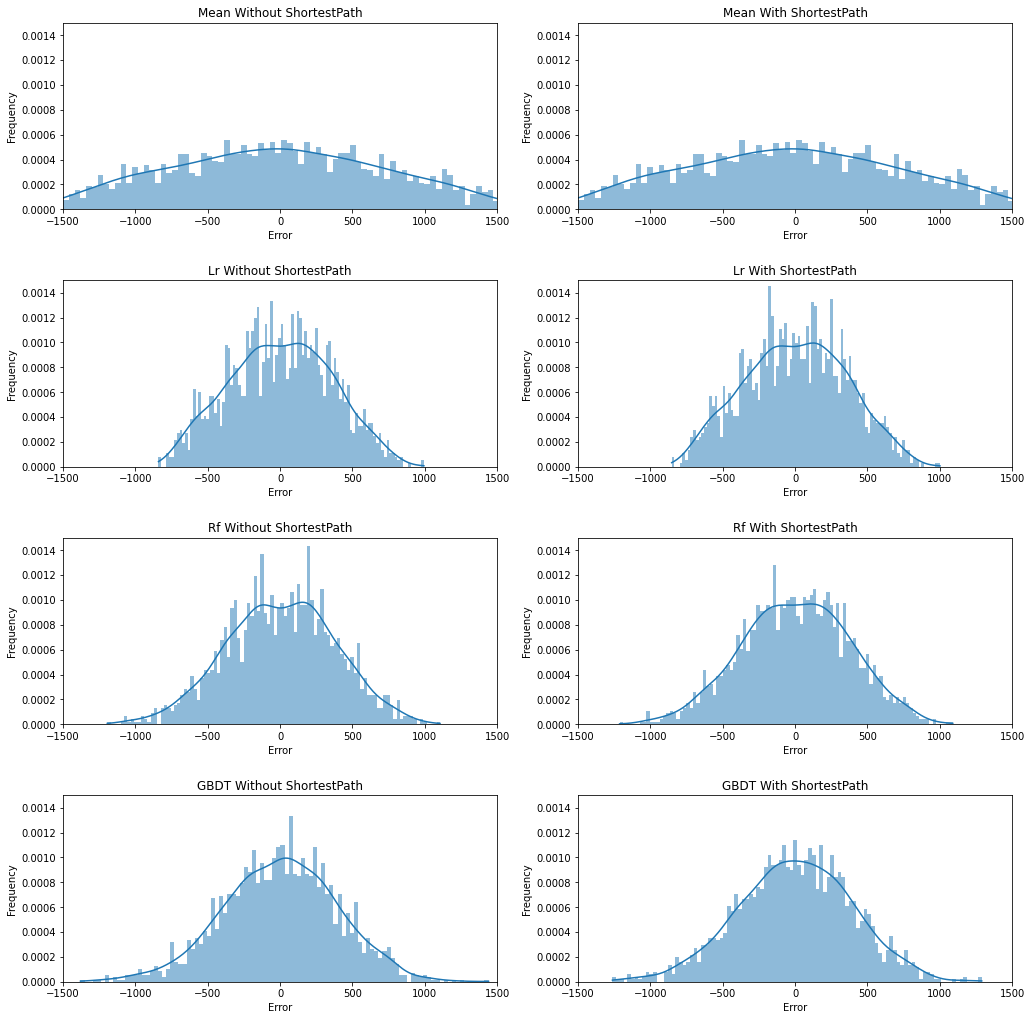

In [51]:
fig, axs = plt.subplots(len(Names), len(X), figsize=(15, 15))
fig.tight_layout(pad=5.0)
for i in range(len(Names)):
    for j in range(len(X)):
        sns.histplot((ys_test-all_predictions_s[j][i]), bins=100, ax=axs[i, j], kde=True, stat="density", linewidth=0)
        axs[i, j].set_title(Names[i]+" "+DataFeats[j])
        axs[i, j].set_xlabel("Error")
        axs[i, j].set_ylabel("Frequency")
        axs[i, j].set_xlim(-1500, 1500)
        axs[i, j].set_ylim(0, 0.0015)

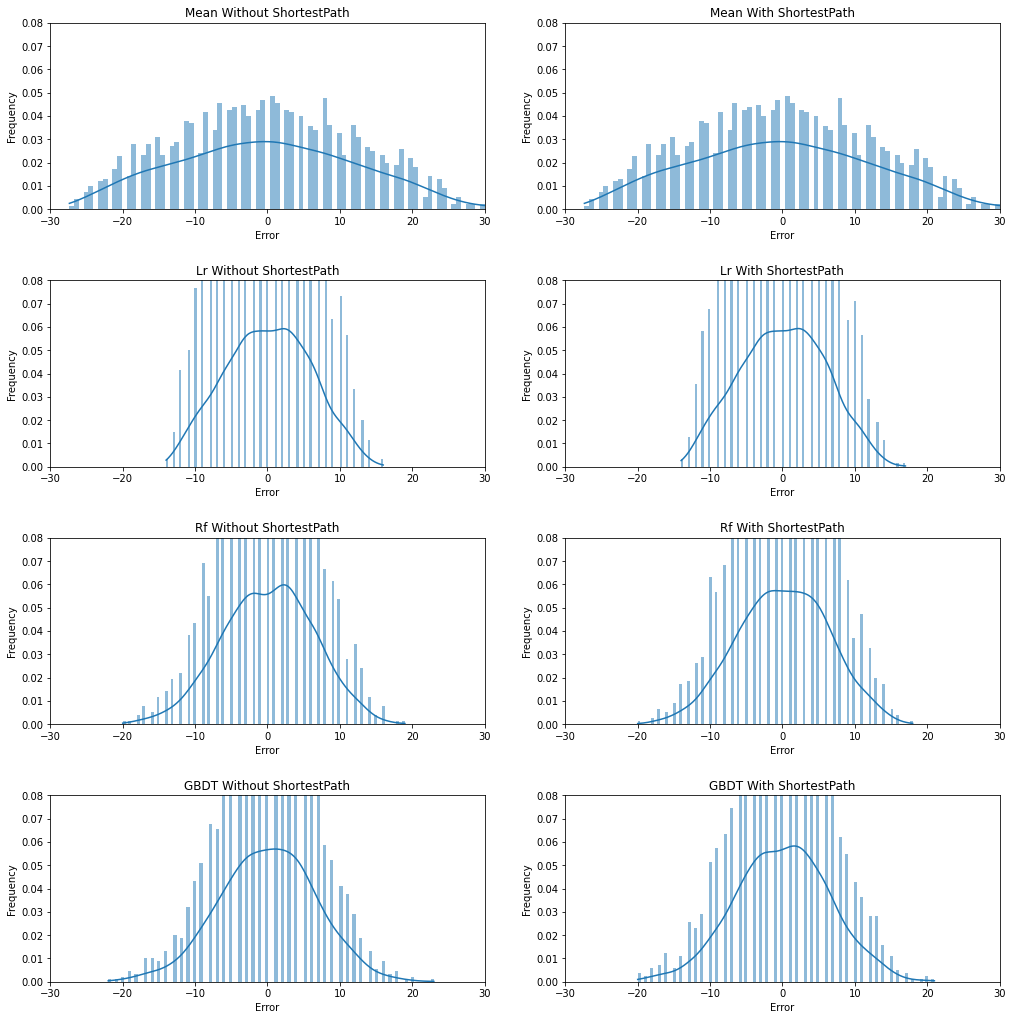

In [53]:
fig, axs = plt.subplots(len(Names), len(X), figsize=(15, 15))
fig.tight_layout(pad=5.0)
for i in range(len(Names)):
    for j in range(len(X)):
        sns.histplot((ym_test-all_predictions_m[j][i]), bins=100, ax=axs[i, j], kde=True, stat="density", linewidth=0)
        axs[i, j].set_title(Names[i]+" "+DataFeats[j])
        axs[i, j].set_xlabel("Error")
        axs[i, j].set_ylabel("Frequency")
        axs[i, j].set_xlim(-30, 30)
        axs[i, j].set_ylim(0, 0.08)

## 6. Hyperparameter tuning

In [1]:
from module.distance_calculator import DistanceCalculator

import numpy as np
import pandas as pd

from math import sqrt, cos

import networkx as nx

import datetime
from datetime import time, date, datetime

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn import metrics


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate

In [2]:
# LOAD CLEANED DATASET
df = pd.read_csv("Sample 14days (cleaned)")
df.loc[df["ShortestDist"]==0, "ShortestDist"] = df.loc[df["ShortestDist"]==0, "EucDist"]

In [3]:
df.head(5)

,JobAcceptedDate,jobAcceptedTime,Merchant.Lat,Merchant.Lng,Customer.lat,Customer.lng,DeliveryTime (s),DeliveryTime (m),EucDist,day_of_week,...,day_of_week_name_Fri,day_of_week_name_Mon,day_of_week_name_Sat,day_of_week_name_Sun,day_of_week_name_Thu,day_of_week_name_Tue,day_of_week_name_Wed,day_of_week_sin,day_of_week_cos,ShortestDist
0,2020-10-03,20:39:15.840000,13.825703,100.559309,13.756065,100.562375,1491.0,25,7750.511440,5,...,0,0,1,0,0,0,0,-0.974928,-0.222521,9679.275
1,2020-10-01,12:54:34.560000,13.831056,100.570731,13.774685,100.573913,2164.0,36,6277.603705,3,...,0,0,0,0,1,0,0,0.433884,-0.900969,7514.353
2,2020-10-01,12:32:06.720000,13.827205,100.536048,13.743898,100.571659,2120.0,35,10029.576224,3,...,0,0,0,0,1,0,0,0.433884,-0.900969,15891.237
3,2020-10-03,13:19:03.360000,13.840180,100.542326,13.803957,100.513704,1722.0,29,5076.637568,5,...,0,0,1,0,0,0,0,-0.974928,-0.222521,10240.074
4,2020-10-13,11:08:26.880000,13.827034,100.564534,13.775817,100.575734,1494.0,25,5822.057209,1,...,0,0,0,0,0,1,0,0.781831,0.623490,7381.359


In [4]:
y_s = df.pop("DeliveryTime (s)")
y_m = df.pop("DeliveryTime (m)")
X = df[["Merchant.Lat", "Merchant.Lng", "Customer.lat", "Customer.lng", "EucDist", "ShortestDist", "day_of_week_sin", "day_of_week_cos"]]
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X, y_s, test_size=0.20, random_state=0)
Xm_train, Xm_test, ym_train, ym_test = train_test_split(X, y_m, test_size=0.20, random_state=0)

In [5]:
import pickle as pkl
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from mpl_toolkits.mplot3d import Axes3D
from pylab import cm
import matplotlib.ticker as mticker

In [6]:
# gbdt = GradientBoostingRegressor(random_state=314159)
# # gbdt.get_params(deep=True)

# param_grid = { 
#  "n_estimators": [100, 200, 300, 500, 1000, 1500, 2000],
#  "max_features": [1.0, "sqrt", "log2"], # "auto" is deprecated, use 1.0 instead
#  "max_depth": [2, 3, 4, 5, 6, 7, 8],
# }

# CV_gbdt_s = GridSearchCV(estimator=gbdt, param_grid=param_grid)
# CV_gbdt_s.fit(Xs_train, ys_train)

In [7]:
# pkl.dump(CV_gbdt_s, open("CV_gbdt_s.pkl", "wb"))

In [6]:
CV_gbdt_s = pkl.load(open("CV_gbdt_s.pkl", "rb"))

In [9]:
# gbdt = GradientBoostingRegressor(random_state=314159)
# # gbdt.get_params(deep=True)

# param_grid = { 
#  "n_estimators": [100, 200, 300, 500, 1000, 1500, 2000],
#  "max_features": [1.0, "sqrt", "log2"], # "auto" is deprecated, use 1.0 instead
#  "max_depth" : [2, 3, 4, 5, 6, 7, 8],
# }

# CV_gbdt_m = GridSearchCV(estimator=gbdt, param_grid=param_grid)
# CV_gbdt_m.fit(Xm_train, ym_train)

In [10]:
# pkl.dump(CV_gbdt_m, open("CV_gbdt_m.pkl", "wb"))

In [7]:
CV_gbdt_m = pkl.load(open("CV_gbdt_m.pkl", "rb"))

In [8]:
gbdt_s = CV_gbdt_s.best_estimator_

In [13]:
# pkl.dump(gbdt_s, open("gbdt_s.pkl", "wb"))

In [9]:
CV_gbdt_s.best_params_

{'max_depth': 2, 'max_features': 1.0, 'n_estimators': 100}

In [10]:
CV_s_result = pd.DataFrame(CV_gbdt_s.cv_results_)

In [11]:
CV_s_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   mean_fit_time       147 non-null    float64
 1   std_fit_time        147 non-null    float64
 2   mean_score_time     147 non-null    float64
 3   std_score_time      147 non-null    float64
 4   param_max_depth     147 non-null    object 
 5   param_max_features  147 non-null    object 
 6   param_n_estimators  147 non-null    object 
 7   params              147 non-null    object 
 8   split0_test_score   147 non-null    float64
 9   split1_test_score   147 non-null    float64
 10  split2_test_score   147 non-null    float64
 11  split3_test_score   147 non-null    float64
 12  split4_test_score   147 non-null    float64
 13  mean_test_score     147 non-null    float64
 14  std_test_score      147 non-null    float64
 15  rank_test_score     147 non-null    int32  
dtypes: float

In [12]:
CV_s_result[["param_max_depth", "param_max_features", "param_n_estimators", "mean_test_score", "std_test_score"]].sort_values(by="mean_test_score", ascending=False)

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score
0,2,1.0,100,0.790618,0.007454
21,3,1.0,100,0.789316,0.007724
1,2,1.0,200,0.789208,0.007498
2,2,1.0,300,0.787700,0.007132
42,4,1.0,100,0.787631,0.007342
...,...,...,...,...,...
104,6,log2,2000,0.717188,0.008779
125,7,log2,2000,0.716954,0.011209
97,6,sqrt,2000,0.716822,0.010009
90,6,1.0,2000,0.716681,0.010075


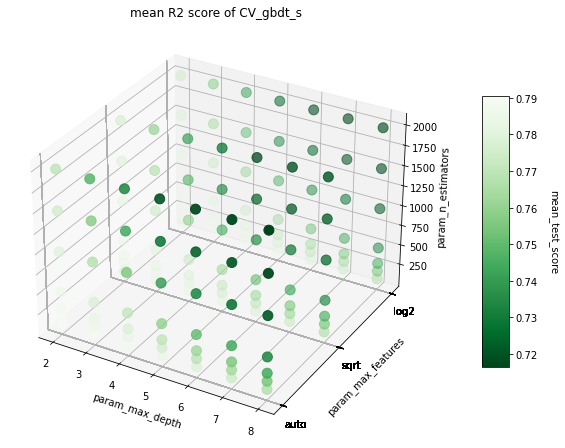

In [13]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

x = CV_s_result["param_max_depth"].values.astype("int")
y = CV_s_result["param_max_features"].map({1.0: 0, "sqrt": 1, "log2": 2}).values.astype("int")
z = CV_s_result["param_n_estimators"].values.astype("int")
colo = CV_s_result["mean_test_score"].values

color_map = cm.ScalarMappable(cmap=cm.Greens_r)
color_map.set_array(colo)

img = ax.scatter(xs=x, ys=y, zs=z, c=colo, cmap=cm.Greens_r, s=100)
cbar = fig.colorbar(img, ticks=np.linspace(0.70, 0.79, 10), orientation='vertical', shrink=0.5, aspect=10, pad=0.1)
cbar.set_label('mean_test_score', rotation=270, labelpad=20)

ax.set_title("mean R2 score of CV_gbdt_s")
ax.set_xlabel('param_max_depth')
ax.set_ylabel('param_max_features')
ax.set_zlabel('param_n_estimators')

ax.axes.yaxis.set_major_locator(mticker.FixedLocator(y))
ax.axes.yaxis.set_ticklabels(CV_s_result["param_max_features"].map({1.0: "auto", "sqrt": "sqrt", "log2": "log2"}))
plt.show()

In [14]:
gbdt_predictions_s = gbdt_s.predict(Xs_test)

MAE  = metrics.mean_absolute_error(ys_test, gbdt_predictions_s)
MSE  = metrics.mean_squared_error(ys_test, gbdt_predictions_s)
R2   = metrics.r2_score(ys_test, gbdt_predictions_s)
RMSE = np.sqrt(metrics.mean_squared_error(ys_test, gbdt_predictions_s))

In [15]:
MAE, MSE, R2, RMSE

(285.804483386762, 119233.04962593749, 0.7905387345348365, 345.3013895511246)

In [16]:
gbdt_predictions_s_round = np.round(gbdt_s.predict(Xs_test))

MAE  = metrics.mean_absolute_error(ys_test, gbdt_predictions_s_round)
MSE  = metrics.mean_squared_error(ys_test, gbdt_predictions_s_round)
R2   = metrics.r2_score(ys_test, gbdt_predictions_s_round)
RMSE = np.sqrt(metrics.mean_squared_error(ys_test, gbdt_predictions_s_round))

In [17]:
MAE, MSE, R2, RMSE

(285.8045, 119237.8175, 0.7905303586278389, 345.3082934132918)

In [18]:
gbdt_s_result = pd.DataFrame({"Actual": ys_test, "Predicted_0": gbdt_predictions_s, "Predicted_1": gbdt_predictions_s_round})
gbdt_s_result

,Actual,Predicted_0,Predicted_1
9394,2413.0,2077.191893,2077.0
898,636.0,634.689349,635.0
2398,1709.0,2317.538751,2318.0
5906,2955.0,3053.066389,3053.0
2343,1074.0,866.614782,867.0
...,...,...,...
1037,747.0,675.713351,676.0
2899,1061.0,1344.122436,1344.0
9549,3231.0,2769.322995,2769.0
2740,3716.0,3063.125000,3063.0


Text(367.48863636363626, 0.5, 'Actual')

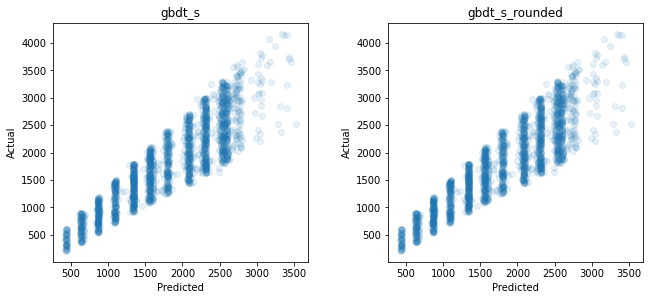

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=5.0)
axs[0].scatter(gbdt_predictions_s, ys_test, alpha=0.1)
axs[0].set_title("gbdt_s")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("Actual")

axs[1].scatter(gbdt_predictions_s_round, ys_test, alpha=0.1)
axs[1].set_title("gbdt_s_rounded")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("Actual")

Text(367.48863636363626, 0.5, 'Predicted')

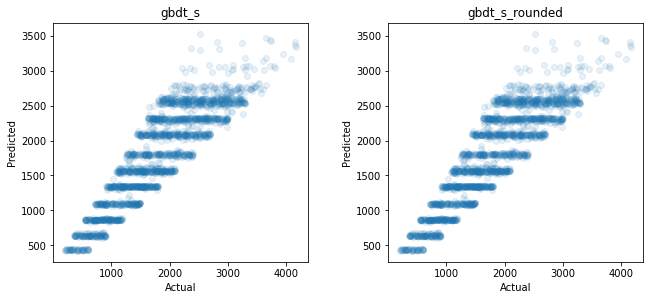

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=5.0)
axs[0].scatter(ys_test, gbdt_predictions_s, alpha=0.1)
axs[0].set_title("gbdt_s")
axs[0].set_xlabel("Actual")
axs[0].set_ylabel("Predicted")

axs[1].scatter(ys_test, gbdt_predictions_s_round, alpha=0.1)
axs[1].set_title("gbdt_s_rounded")
axs[1].set_xlabel("Actual")
axs[1].set_ylabel("Predicted")

Text(367.48863636363626, 0.5, 'Actual/Predicted')

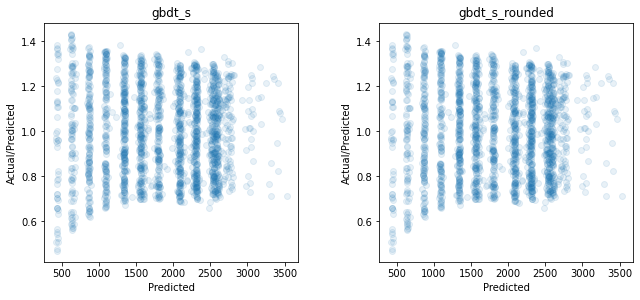

In [21]:

# TODO pred/act plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=5.0)
axs[0].scatter(gbdt_predictions_s, ys_test/gbdt_predictions_s, alpha=0.1)
axs[0].set_title("gbdt_s")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("Actual/Predicted")

axs[1].scatter(gbdt_predictions_s_round, ys_test/gbdt_predictions_s_round, alpha=0.1)
axs[1].set_title("gbdt_s_rounded")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("Actual/Predicted")

Text(367.48863636363626, 0.5, 'Predicted')

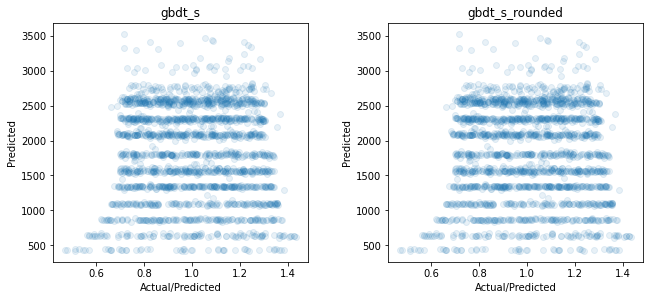

In [22]:

# TODO pred/act plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=5.0)
axs[0].scatter(ys_test/gbdt_predictions_s, gbdt_predictions_s, alpha=0.1)
axs[0].set_title("gbdt_s")
axs[0].set_xlabel("Actual/Predicted")
axs[0].set_ylabel("Predicted")

axs[1].scatter(ys_test/gbdt_predictions_s_round, gbdt_predictions_s_round,alpha=0.1)
axs[1].set_title("gbdt_s_rounded")
axs[1].set_xlabel("Actual/Predicted")
axs[1].set_ylabel("Predicted")

Text(367.48863636363626, 0.5, 'Actual/Predicted')

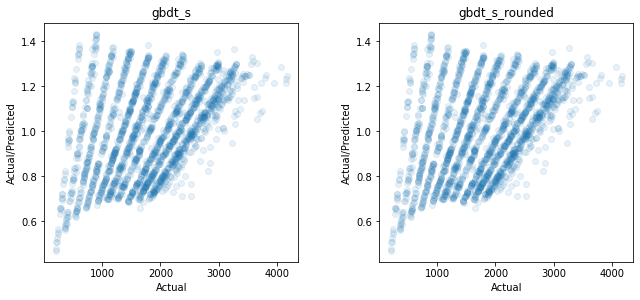

In [55]:

# TODO act, act/pred plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=5.0)
axs[0].scatter(ys_test, ys_test/gbdt_predictions_s, alpha=0.1)
axs[0].set_title("gbdt_s")
axs[0].set_xlabel("Actual")
axs[0].set_ylabel("Actual/Predicted")

axs[1].scatter(ys_test, ys_test/gbdt_predictions_s_round, alpha=0.1)
axs[1].set_title("gbdt_s_rounded")
axs[1].set_xlabel("Actual")
axs[1].set_ylabel("Actual/Predicted")

(0.0, 0.0015)

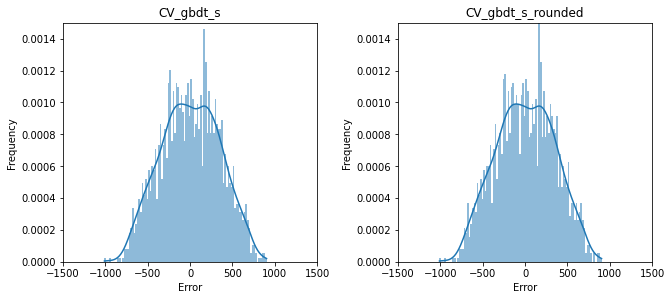

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=5.0)

sns.histplot((ys_test-gbdt_predictions_s), bins=100, ax=axs[0], kde=True, stat="density", linewidth=0)
axs[0].set_title("CV_gbdt_s")
axs[0].set_xlabel("Error")
axs[0].set_ylabel("Frequency")
axs[0].set_xlim(-1500, 1500)
axs[0].set_ylim(0, 0.0015)

sns.histplot((ys_test-gbdt_predictions_s_round), bins=100, ax=axs[1], kde=True, stat="density", linewidth=0)
axs[1].set_title("CV_gbdt_s_rounded")
axs[1].set_xlabel("Error")
axs[1].set_ylabel("Frequency")
axs[1].set_xlim(-1500, 1500)
axs[1].set_ylim(0, 0.0015)

#### for m

In [24]:
gbdt_m = CV_gbdt_m.best_estimator_

In [25]:
gbdt_m.feature_importances_

array([4.34491258e-04, 2.88411087e-04, 1.27892523e-03, 1.22297903e-03,
       9.95208137e-01, 9.64568575e-04, 4.89389403e-04, 1.13098901e-04])

In [26]:
# pkl.dump(gbdt_m, open("gbdt_m.pkl", "wb"))

In [27]:
CV_gbdt_m.best_params_

{'max_depth': 2, 'max_features': 1.0, 'n_estimators': 100}

In [28]:
pd.DataFrame(CV_gbdt_m.cv_results_).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.476395,0.003381,0.002607,0.000492,2,1.0,100,"{'max_depth': 2, 'max_features': 1.0, 'n_estim...",0.780146,0.783117,0.792259,0.798303,0.795335,0.789832,0.007026,1
1,0.948198,0.008517,0.003198,0.000395,2,1.0,200,"{'max_depth': 2, 'max_features': 1.0, 'n_estim...",0.778857,0.781463,0.790952,0.796442,0.794706,0.788484,0.007073,2
2,1.439401,0.022516,0.003804,0.000402,2,1.0,300,"{'max_depth': 2, 'max_features': 1.0, 'n_estim...",0.777965,0.780225,0.789315,0.795078,0.792481,0.787013,0.006755,4
3,2.350514,0.011198,0.005797,0.000745,2,1.0,500,"{'max_depth': 2, 'max_features': 1.0, 'n_estim...",0.775059,0.779503,0.788007,0.791758,0.787714,0.784408,0.006154,10
4,4.709467,0.038973,0.009812,0.000404,2,1.0,1000,"{'max_depth': 2, 'max_features': 1.0, 'n_estim...",0.769652,0.774679,0.784575,0.787323,0.777870,0.778820,0.006443,34


In [29]:
CV_m_result = pd.DataFrame(CV_gbdt_m.cv_results_)

In [30]:
CV_m_result[["param_max_depth", "param_max_features", "param_n_estimators", "mean_test_score", "std_test_score"]].sort_values(by="mean_test_score", ascending=False)

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score
0,2,1.0,100,0.789832,0.007026
1,2,1.0,200,0.788484,0.007073
21,3,1.0,100,0.788242,0.006585
2,2,1.0,300,0.787013,0.006755
42,4,1.0,100,0.786880,0.007127
...,...,...,...,...,...
110,7,1.0,1500,0.716099,0.010600
118,7,sqrt,2000,0.716047,0.009832
132,8,1.0,2000,0.715564,0.010829
111,7,1.0,2000,0.713516,0.010928


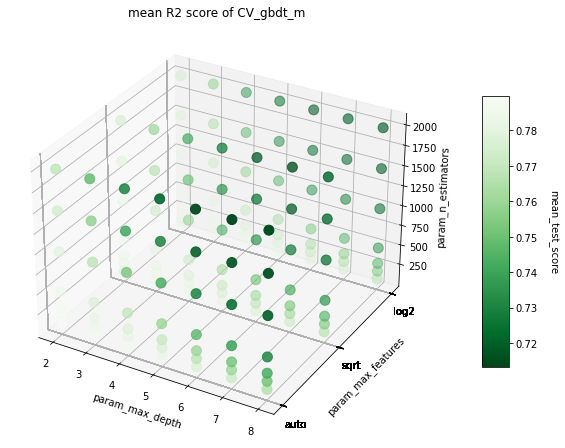

In [31]:
fig = plt.figure(figsize=(10, 10))
fig.tight_layout(pad=5.0)
ax = fig.add_subplot(111, projection='3d')

x = CV_m_result["param_max_depth"].values.astype("int")
y = CV_m_result["param_max_features"].map({1.0: 0, "sqrt": 1, "log2": 2}).values.astype("int")
z = CV_m_result["param_n_estimators"].values.astype("int")
colo = CV_m_result["mean_test_score"].values

color_map = cm.ScalarMappable(cmap=cm.Greens_r)
color_map.set_array(colo)

img = ax.scatter(xs=x, ys=y, zs=z, c=colo, cmap=cm.Greens_r, s=100)
cbar = fig.colorbar(img, ticks=np.linspace(0.70, 0.79, 10), orientation='vertical', shrink=0.5, aspect=10, pad=0.1)
cbar.set_label('mean_test_score', rotation=270, labelpad=20)

ax.set_title("mean R2 score of CV_gbdt_m")
ax.set_xlabel('param_max_depth')
ax.set_ylabel('param_max_features')
ax.set_zlabel('param_n_estimators')

ax.axes.yaxis.set_major_locator(mticker.FixedLocator(y))
ax.axes.yaxis.set_ticklabels(CV_m_result["param_max_features"].map({1.0: "auto", "sqrt": "sqrt", "log2": "log2"}))
plt.show()

In [32]:
gbdt_predictions_m = gbdt_m.predict(Xm_test)

MAE  = metrics.mean_absolute_error(ym_test, gbdt_predictions_m)
MSE  = metrics.mean_squared_error(ym_test, gbdt_predictions_m)
R2   = metrics.r2_score(ym_test, gbdt_predictions_m)
RMSE = np.sqrt(metrics.mean_squared_error(ym_test, gbdt_predictions_m))

In [33]:
MAE, MSE, R2, RMSE

(4.780436869768586, 33.36136187835141, 0.7891685686326413, 5.775929525050614)

In [34]:
gbdt_predictions_m_round = np.round(gbdt_m.predict(Xm_test))

MAE  = metrics.mean_absolute_error(ym_test, gbdt_predictions_m_round)
MSE  = metrics.mean_squared_error(ym_test, gbdt_predictions_m_round)
R2   = metrics.r2_score(ym_test, gbdt_predictions_m_round)
RMSE = np.sqrt(metrics.mean_squared_error(ym_test, gbdt_predictions_m_round))

In [35]:
MAE, MSE, R2, RMSE

(4.766, 33.466, 0.7885072945202951, 5.784980553122025)

In [36]:
gbdt_m_result = pd.DataFrame({"Actual": ym_test, "Predicted_0": gbdt_predictions_m, "Predicted_1": gbdt_predictions_m_round})
gbdt_m_result

,Actual,Predicted_0,Predicted_1
9394,40,34.594685,35.0
898,11,10.572828,11.0
2398,28,38.601664,39.0
5906,49,50.612899,51.0
2343,18,14.503851,15.0
...,...,...,...
1037,12,11.137640,11.0
2899,18,22.405936,22.0
9549,54,45.758132,46.0
2740,62,51.131389,51.0


Text(367.48863636363626, 0.5, 'Actual')

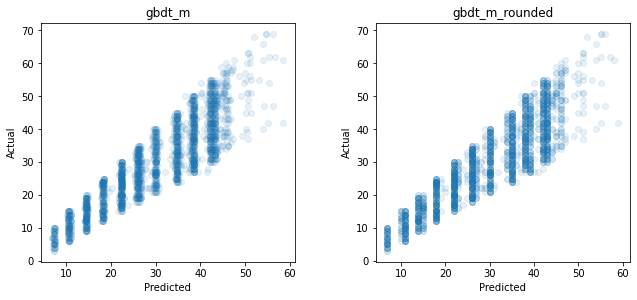

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=5.0)
axs[0].scatter(gbdt_predictions_m, ym_test, alpha=0.1)
axs[0].set_title("gbdt_m")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("Actual")

axs[1].scatter(gbdt_predictions_m_round, ym_test, alpha=0.1)
axs[1].set_title("gbdt_m_rounded")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("Actual")

Text(367.48863636363626, 0.5, 'Predicted')

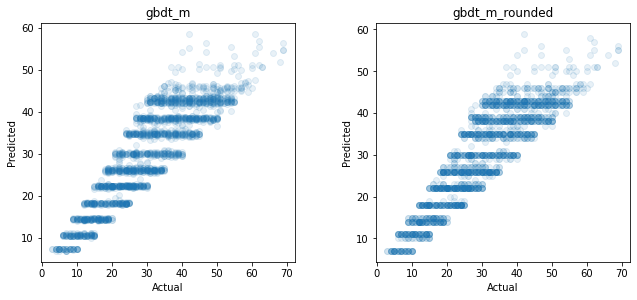

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=5.0)
axs[0].scatter(ym_test, gbdt_predictions_m, alpha=0.1)
axs[0].set_title("gbdt_m")
axs[0].set_xlabel("Actual")
axs[0].set_ylabel("Predicted")

axs[1].scatter(ym_test,gbdt_predictions_m_round, alpha=0.1)
axs[1].set_title("gbdt_m_rounded")
axs[1].set_xlabel("Actual")
axs[1].set_ylabel("Predicted")

Text(367.48863636363626, 0.5, 'Actual/Predicted')

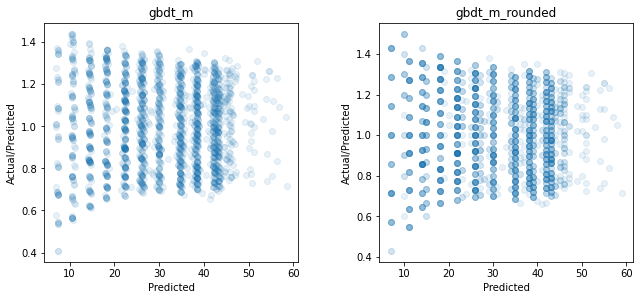

In [39]:

# TODO pred/act plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=5.0)
axs[0].scatter(gbdt_predictions_m, ym_test/gbdt_predictions_m, alpha=0.1)
axs[0].set_title("gbdt_m")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("Actual/Predicted")

axs[1].scatter(gbdt_predictions_m_round, ym_test/gbdt_predictions_m_round, alpha=0.1)
axs[1].set_title("gbdt_m_rounded")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("Actual/Predicted")

Text(367.48863636363626, 0.5, 'Predicted')

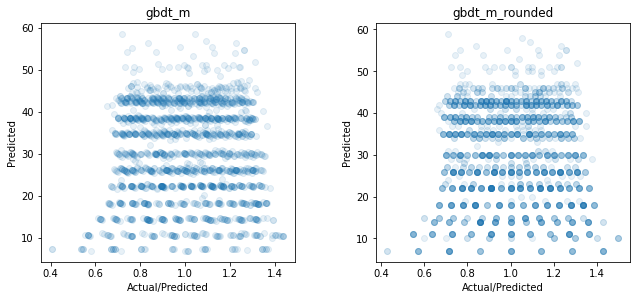

In [40]:

# TODO pred/act plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=5.0)
axs[0].scatter(ym_test/gbdt_predictions_m, gbdt_predictions_m, alpha=0.1)
axs[0].set_title("gbdt_m")
axs[0].set_xlabel("Actual/Predicted")
axs[0].set_ylabel("Predicted")

axs[1].scatter(ym_test/gbdt_predictions_m_round, gbdt_predictions_m_round, alpha=0.1)
axs[1].set_title("gbdt_m_rounded")
axs[1].set_xlabel("Actual/Predicted")
axs[1].set_ylabel("Predicted")

Text(367.48863636363626, 0.5, 'Actual/Predicted')

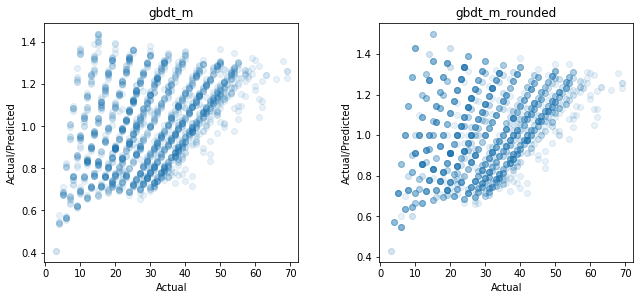

In [59]:

# TODO act, act/pred plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=5.0)
axs[0].scatter(ym_test, ym_test/gbdt_predictions_m, alpha=0.1)
axs[0].set_title("gbdt_m")
axs[0].set_xlabel("Actual")
axs[0].set_ylabel("Actual/Predicted")

axs[1].scatter(ym_test, ym_test/gbdt_predictions_m_round, alpha=0.1)
axs[1].set_title("gbdt_m_rounded")
axs[1].set_xlabel("Actual")
axs[1].set_ylabel("Actual/Predicted")

## compare gbdt s,m

(0.35, 1.5)

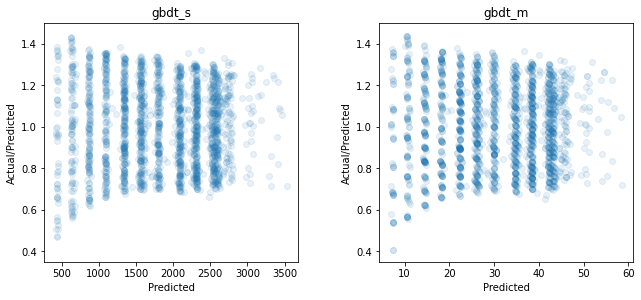

In [41]:

# TODO pred/act plot s/m
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=5.0)
axs[0].scatter(gbdt_predictions_s, ys_test/gbdt_predictions_s, alpha=0.1)
axs[0].set_title("gbdt_s")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("Actual/Predicted")
axs[0].set_ylim(0.35, 1.5)

axs[1].scatter(gbdt_predictions_m, ym_test/gbdt_predictions_m, alpha=0.1)
axs[1].set_title("gbdt_m")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("Actual/Predicted")
axs[1].set_ylim(0.35, 1.5)

(0.35, 1.5)

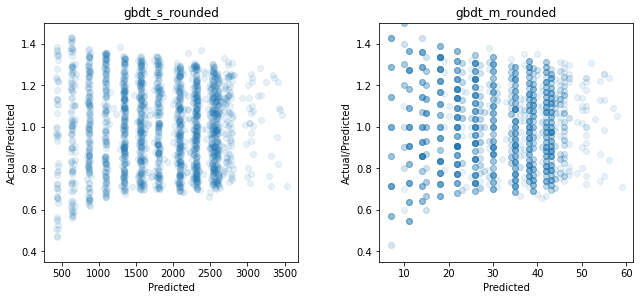

In [42]:

# TODO pred/act plot s/m rounded
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=5.0)
axs[0].scatter(gbdt_predictions_s_round, ys_test/gbdt_predictions_s_round, alpha=0.1)
axs[0].set_title("gbdt_s_rounded")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("Actual/Predicted")
axs[0].set_ylim(0.35, 1.5)

axs[1].scatter(gbdt_predictions_m_round, ym_test/gbdt_predictions_m_round, alpha=0.1)
axs[1].set_title("gbdt_m_rounded")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("Actual/Predicted")
axs[1].set_ylim(0.35, 1.5)

(0.35, 1.5)

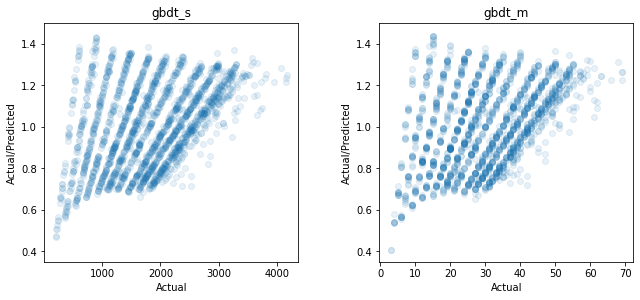

In [65]:

# TODO act, act/pred plot s/m
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=5.0)
axs[0].scatter(ys_test, ys_test/gbdt_predictions_s, alpha=0.1)
axs[0].set_title("gbdt_s")
axs[0].set_xlabel("Actual")
axs[0].set_ylabel("Actual/Predicted")
axs[0].set_ylim(0.35, 1.5)

axs[1].scatter(ym_test, ym_test/gbdt_predictions_m, alpha=0.1)
axs[1].set_title("gbdt_m")
axs[1].set_xlabel("Actual")
axs[1].set_ylabel("Actual/Predicted")
axs[1].set_ylim(0.35, 1.5)

(0.35, 1.5)

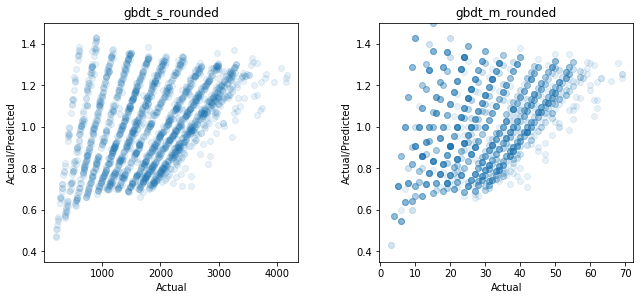

In [66]:

# TODO pred/act plot s/m rounded
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=5.0)
axs[0].scatter(ys_test, ys_test/gbdt_predictions_s_round, alpha=0.1)
axs[0].set_title("gbdt_s_rounded")
axs[0].set_xlabel("Actual")
axs[0].set_ylabel("Actual/Predicted")
axs[0].set_ylim(0.35, 1.5)

axs[1].scatter(ym_test, ym_test/gbdt_predictions_m_round, alpha=0.1)
axs[1].set_title("gbdt_m_rounded")
axs[1].set_xlabel("Actual")
axs[1].set_ylabel("Actual/Predicted")
axs[1].set_ylim(0.35, 1.5)

(0.35, 1.5)

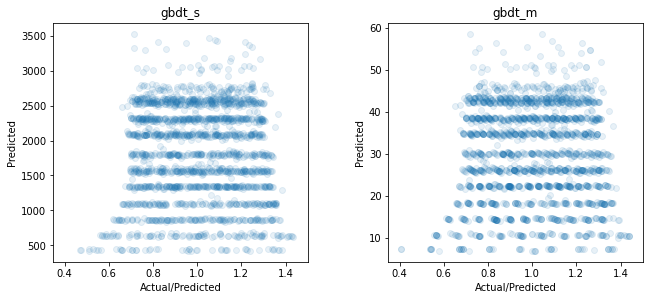

In [67]:

# TODO pred/act plot s/m
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=5.0)
axs[0].scatter(ys_test/gbdt_predictions_s, gbdt_predictions_s, alpha=0.1)
axs[0].set_title("gbdt_s")
axs[0].set_xlabel("Actual/Predicted")
axs[0].set_ylabel("Predicted")
axs[0].set_xlim(0.35, 1.5)

axs[1].scatter(ym_test/gbdt_predictions_m, gbdt_predictions_m, alpha=0.1)
axs[1].set_title("gbdt_m")
axs[1].set_xlabel("Actual/Predicted")
axs[1].set_ylabel("Predicted")
axs[1].set_xlim(0.35, 1.5)

(0.35, 1.5)

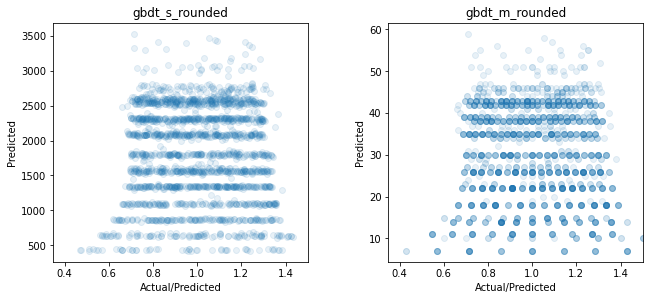

In [63]:

# TODO pred/act plot s/m rounded
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=5.0)
axs[0].scatter(ys_test/gbdt_predictions_s_round, gbdt_predictions_s_round, alpha=0.1)
axs[0].set_title("gbdt_s_rounded")
axs[0].set_xlabel("Actual/Predicted")
axs[0].set_ylabel("Predicted")
axs[0].set_xlim(0.35, 1.5)

axs[1].scatter(ym_test/gbdt_predictions_m_round, gbdt_predictions_m_round, alpha=0.1)
axs[1].set_title("gbdt_m_rounded")
axs[1].set_xlabel("Actual/Predicted")
axs[1].set_ylabel("Predicted")
axs[1].set_xlim(0.35, 1.5)

(0.0, 0.08)

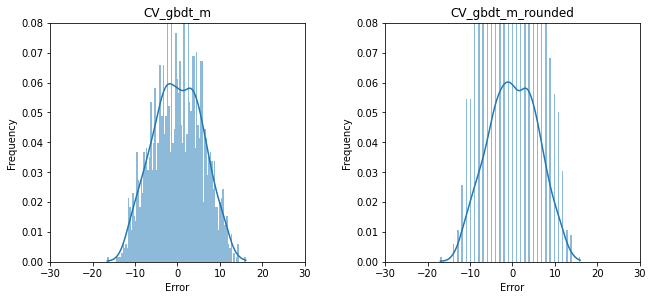

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=5.0)

sns.histplot((ym_test-gbdt_predictions_m), bins=100, ax=axs[0], kde=True, stat="density", linewidth=0)
axs[0].set_title("CV_gbdt_m")
axs[0].set_xlabel("Error")
axs[0].set_ylabel("Frequency")
axs[0].set_xlim(-30, 30)
axs[0].set_ylim(0, 0.08)

sns.histplot((ym_test-gbdt_predictions_m_round), bins=100, ax=axs[1], kde=True, stat="density", linewidth=0)
axs[1].set_title("CV_gbdt_m_rounded")
axs[1].set_xlabel("Error")
axs[1].set_ylabel("Frequency")
axs[1].set_xlim(-30, 30)
axs[1].set_ylim(0, 0.08)

In [46]:
gbdt_m_result["AE_0"] = np.abs(gbdt_m_result["Actual"] - gbdt_m_result["Predicted_0"])
gbdt_m_result["AE_1"] = np.abs(gbdt_m_result["Actual"] - gbdt_m_result["Predicted_1"])
gbdt_m_result.head(1)

,Actual,Predicted_0,Predicted_1,AE_0,AE_1
9394,40,34.594685,35.0,5.405315,5.0


In [47]:
gbdt_m_result

,Actual,Predicted_0,Predicted_1,AE_0,AE_1
9394,40,34.594685,35.0,5.405315,5.0
898,11,10.572828,11.0,0.427172,0.0
2398,28,38.601664,39.0,10.601664,11.0
5906,49,50.612899,51.0,1.612899,2.0
2343,18,14.503851,15.0,3.496149,3.0
...,...,...,...,...,...
1037,12,11.137640,11.0,0.862360,1.0
2899,18,22.405936,22.0,4.405936,4.0
9549,54,45.758132,46.0,8.241868,8.0
2740,62,51.131389,51.0,10.868611,11.0


In [48]:
# TODO: try to group AE_0 to cateorical
gbdt_m_pareto_0 = gbdt_m_result.value_counts("AE_0").sort_index().to_frame().reset_index()
# gbdt_m_pareto_1.index = gbdt_m_pareto_1["AE_1"].values.astype(str)
# gbdt_m_pareto_1["AE_1"] = gbdt_m_pareto_1[0]
# gbdt_m_pareto_1.drop(columns=[0], inplace=True)
# gbdt_m_pareto_1["cumpercentage"] = gbdt_m_pareto_1["AE_1"].cumsum()/gbdt_m_pareto_1["AE_1"].sum()*100
# gbdt_m_pareto_1.head(3)

gbdt_m_pareto_0.value_counts()

AE_0       0
0.003088   1    1
6.196276   1    1
6.188405   3    1
6.169836   1    1
6.168994   1    1
               ..
2.899197   1    1
2.881738   1    1
2.879270   1    1
2.878574   1    1
16.546084  1    1
Length: 1717, dtype: int64

In [49]:
# for AE_1 it is integer
from matplotlib.ticker import PercentFormatter
gbdt_m_pareto_1 = gbdt_m_result.value_counts("AE_1").sort_index().to_frame().reset_index()
gbdt_m_pareto_1.index = gbdt_m_pareto_1["AE_1"].values.astype(str)
gbdt_m_pareto_1["AE_1"] = gbdt_m_pareto_1[0]
gbdt_m_pareto_1.drop(columns=[0], inplace=True)
gbdt_m_pareto_1["cumpercentage"] = gbdt_m_pareto_1["AE_1"].cumsum()/gbdt_m_pareto_1["AE_1"].sum()*100
gbdt_m_pareto_1.head(3)

,AE_1,cumpercentage
0.0,129,6.45
1.0,225,17.70
2.0,231,29.25


In [50]:
gbdt_m_pareto_1

,AE_1,cumpercentage
0.0,129,6.45
1.0,225,17.70
2.0,231,29.25
3.0,242,41.35
4.0,229,52.80
5.0,201,62.85
6.0,175,71.60
7.0,142,78.70
8.0,123,84.85
9.0,98,89.75


In [51]:
129/2000*100

6.45

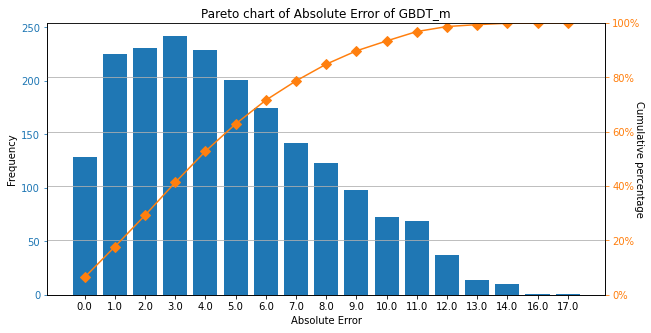

In [68]:
# TODO pareto chart of AE_1
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(gbdt_m_pareto_1.index, gbdt_m_pareto_1["AE_1"], color="C0")
ax2 = ax.twinx()
ax2.plot(gbdt_m_pareto_1.index, gbdt_m_pareto_1["cumpercentage"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.set_ylim(0, 100) # TODO : tell Boat to add this line
ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")
plt.title("Pareto chart of Absolute Error of GBDT_m")
plt.xlabel("AE_1")
ax.set_ylabel("Frequency")
ax.set_xlabel("Absolute Error")
ax2.set_ylabel("Cumulative percentage", rotation=270)
plt.grid()
plt.show()

In [53]:
gbdt_m_result

,Actual,Predicted_0,Predicted_1,AE_0,AE_1
9394,40,34.594685,35.0,5.405315,5.0
898,11,10.572828,11.0,0.427172,0.0
2398,28,38.601664,39.0,10.601664,11.0
5906,49,50.612899,51.0,1.612899,2.0
2343,18,14.503851,15.0,3.496149,3.0
...,...,...,...,...,...
1037,12,11.137640,11.0,0.862360,1.0
2899,18,22.405936,22.0,4.405936,4.0
9549,54,45.758132,46.0,8.241868,8.0
2740,62,51.131389,51.0,10.868611,11.0


In [ ]:
#Mon 26 Dec 65
#TODO Error dist for CV_gbdt_s,m -- done
#TODO pred/actual dist for CV_gbdt_s,m (similar to error dist)
#TODO hyperparameters - score, time, error dist -- done

# X-ต้น Y-ตาม

In [ ]:
#Mon 2 Jan 66
#TODO: plot X=actual, Y=actual/predicted for all gbdt_s and m
#TODO: fix y-axis of percentage in pareto (0, 100) ylim

## 7. Model Deployment (ONNX)

In [28]:
from skl2onnx import __max_supported_opset__
print("Last supported opset:", __max_supported_opset__)

Last supported opset: 17


In [30]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Merchant.Lat     10000 non-null  float64
 1   Merchant.Lng     10000 non-null  float64
 2   Customer.lat     10000 non-null  float64
 3   Customer.lng     10000 non-null  float64
 4   EucDist          10000 non-null  float64
 5   ShortestDist     10000 non-null  float64
 6   day_of_week_sin  10000 non-null  float64
 7   day_of_week_cos  10000 non-null  float64
dtypes: float64(8)
memory usage: 625.1 KB


In [33]:
gbdt_s = pkl.load(open("gbdt_s.pkl", "rb"))
gbdt_m = pkl.load(open("gbdt_m.pkl", "rb"))

In [34]:
gbdt_s

GradientBoostingRegressor(max_depth=2, max_features=1.0, random_state=314159)

In [35]:
gbdt_m

GradientBoostingRegressor(max_depth=2, max_features=1.0, random_state=314159)

In [82]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

In [77]:
X.shape

(10000, 8)

In [78]:
Xs_train[:1]

,Merchant.Lat,Merchant.Lng,Customer.lat,Customer.lng,EucDist,ShortestDist,day_of_week_sin,day_of_week_cos
7389,13.82462,100.563396,13.757419,100.561038,7476.804115,9947.421,-0.781831,0.62349


In [90]:
Xs_train.astype(np.float32).values[:1]

array([[ 1.38246202e+01,  1.00563393e+02,  1.37574186e+01,
         1.00561035e+02,  7.47680420e+03,  9.94742090e+03,
        -7.81831503e-01,  6.23489797e-01]], dtype=float32)

In [91]:
np.arange(20).reshape(10, 2)

array([[ 0,  1],
       [ 2,  3],
       [ 4,  5],
       [ 6,  7],
       [ 8,  9],
       [10, 11],
       [12, 13],
       [14, 15],
       [16, 17],
       [18, 19]])

In [88]:
initial_type = [("X", Xs_train.astype(np.float32).values)]
onx = convert_sklearn(gbdt_s, initial_types=initial_type)
with open("gbdt_s.onnx", "wb") as f:
    f.write(onx.SerializeToString())

TypeError: shape must be a DataType not [[ 1.38246202e+01  1.00563393e+02  1.37574186e+01 ...  9.94742090e+03
  -7.81831503e-01  6.23489797e-01]
 [ 1.38272047e+01  1.00536049e+02  1.37518549e+01 ...  1.13916113e+04
   9.74927902e-01 -2.22520933e-01]
 [ 1.38249083e+01  1.00569260e+02  1.37780094e+01 ...  6.44368018e+03
   9.74927902e-01 -2.22520933e-01]
 ...
 [ 1.38270340e+01  1.00564537e+02  1.38320179e+01 ...  7.18306787e+03
   7.81831503e-01  6.23489797e-01]
 [ 1.38246202e+01  1.00563393e+02  1.37805920e+01 ...  7.99126318e+03
   7.81831503e-01  6.23489797e-01]
 [ 1.38270340e+01  1.00564537e+02  1.37788515e+01 ...  6.87389209e+03
   0.00000000e+00  1.00000000e+00]].

In [62]:
import onnxruntime as rt

In [63]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Merchant.Lat     10000 non-null  float64
 1   Merchant.Lng     10000 non-null  float64
 2   Customer.lat     10000 non-null  float64
 3   Customer.lng     10000 non-null  float64
 4   EucDist          10000 non-null  float64
 5   ShortestDist     10000 non-null  float64
 6   day_of_week_sin  10000 non-null  float64
 7   day_of_week_cos  10000 non-null  float64
dtypes: float64(8)
memory usage: 625.1 KB


In [64]:
Xs_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 9394 to 6690
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Merchant.Lat     2000 non-null   float64
 1   Merchant.Lng     2000 non-null   float64
 2   Customer.lat     2000 non-null   float64
 3   Customer.lng     2000 non-null   float64
 4   EucDist          2000 non-null   float64
 5   ShortestDist     2000 non-null   float64
 6   day_of_week_sin  2000 non-null   float64
 7   day_of_week_cos  2000 non-null   float64
dtypes: float64(8)
memory usage: 140.6 KB


In [67]:
sess = rt.InferenceSession("gbdt_s.onnx")
pred_ort = sess.run(None, {'X': Xs_test.astype(np.float32)})[0]

InvalidGraph: [ONNXRuntimeError] : 10 : INVALID_GRAPH : Load model from gbdt_s.onnx failed:This is an invalid model. In Node, ("TreeEnsembleRegressor", TreeEnsembleRegressor, "ai.onnx.ml", -1) : ("float_input": tensor(double),) -> ("variable": tensor(double),) , Error Mismatched attribute type in 'TreeEnsembleRegressor : base_values'

In [60]:
np.random.rand(2,7).astype('float32')

array([[0.41792876, 0.4516168 , 0.6742732 , 0.7751213 , 0.93655276,
        0.56512773, 0.30268365],
       [0.33545208, 0.6855824 , 0.568534  , 0.61769307, 0.32648098,
        0.5196443 , 0.9789491 ]], dtype=float32)

In [241]:
df

,JobAcceptedDate,jobAcceptedTime,calledMerchantTime,arrivedAtMerchantTime,mealPickedUpTime,arrivedAtCustLocationTime,foodDeliveredTime,riderInitial.lat,riderInitial.long,Merchant.Lat,Merchant.Lng,Customer.lat,Customer.lng,MerchantName,NationFoodCategory,FoodCategories
0,2020-10-03,20:39:15.840000,20:40:51.840000,20:48:19.840000,20:49:18.840000,21:14:09.840000,21:15:12.840000,13.825853,100.551958,13.825703,100.559309,13.756065,100.562375,3K SEA ZABB,Thai,อาหารทะเล
1,2020-10-01,12:54:34.560000,12:55:38.560000,13:10:26.560000,13:24:56.560000,14:01:00.560000,14:01:39.560000,13.819283,100.561874,13.831056,100.570731,13.774685,100.573913,ร้านอาหารอีสานแม่อลิส,Thai,อาหารอีสาน
2,2020-10-01,12:32:06.720000,12:32:21.720000,12:41:08.720000,12:46:41.720000,13:22:01.720000,13:22:53.720000,13.827041,100.554284,13.827205,100.536048,13.743898,100.571659,ไก่ย่างห้าดาว กรุงเทพ-นนท์44,Thai,Fast Food
3,2020-10-03,13:19:03.360000,13:20:04.360000,13:32:37.360000,13:45:46.360000,14:14:28.360000,14:15:47.360000,13.820453,100.557910,13.840180,100.542326,13.803957,100.513704,กิวกิวเต้ ประชาชื่น,Japanese,ปิ้งย่าง
4,2020-10-13,11:08:26.880000,11:09:03.880000,11:13:43.880000,11:15:32.880000,11:40:26.880000,11:41:23.880000,13.825773,100.567170,13.827034,100.564534,13.775817,100.575734,ร้านอาหาร วินเทส,Thai,อาหารตามสั่ง
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2020-10-04,20:37:58.080000,20:39:09.080000,20:47:30.080000,20:56:32.080000,21:41:24.080000,21:42:36.080000,13.820017,100.556861,13.831056,100.570731,13.740277,100.566035,ร้านอาหารอีสานแม่อลิส,Thai,อาหารอีสาน
9996,2020-10-05,08:13:55.200000,08:15:04.200000,08:20:39.200000,08:21:02.200000,09:09:09.200000,09:10:09.200000,13.827171,100.562291,13.827034,100.564534,13.739573,100.555864,ร้านใบเตย,Thai,อาหารตามสั่ง
9997,2020-10-04,16:39:47.520000,16:40:32.520000,16:53:14.520000,17:06:44.520000,17:31:06.520000,17:31:59.520000,13.823671,100.550038,13.836996,100.540408,13.875017,100.516766,Hia Lek,Thai,อาหารตามสั่ง
9998,2020-10-03,12:05:19.680000,12:05:57.680000,12:18:46.680000,12:22:14.680000,13:22:47.680000,13:23:51.680000,13.820751,100.563062,13.839923,100.547567,13.770979,100.630330,Beer Hima,Thai,อาหารทะเล
